# Welcome to the Group9's notebook with the code for DBL Process Mining Q3 2021.

#### The notebook consists of several parts corresponding to the models/techniques we are using to predict the next events in their chains, as well as the times of finishing those events. These are:

### 1) The baseline model

### 1.5) The Triagram method

(The Triagram method is not a model on its own but is capable of partial predictions by itself, so we will be using it to enchance the other prediction methods)

### 2) The cluster-tree model

### 3) The Markov chain model

#### Before these, we will dedicate some code to load the data and split it into a training, validation and test datasets

# Manual and the models' calls in a nutshell:

### 1) The baseline:

Call with run_baseline(df, df_train, df_test). If (full) df provided, predictions are done on the entire data plugged in and this entire dataset is returned. If df_train and df_test provided (split before using), model is trained on the train data and predictions are done on test data. Test dataset returned only.

### 2) The cluster-tree model:

Call with run_cluster_alg(df_train, df_test). Automatically uses the triagram within it (?). Test dataset returned only.

### 3) Markov Chain model:

Call with run_markov_alg(df_train, df_validation). Automatically uses triagram within it (?). Validation dataset returned only.

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import datetime
import random
import time
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn import preprocessing as pre
from sklearn import tree
import matplotlib.pyplot as plt
from collections import Counter
import math
import tracemalloc
import psutil
from sklearn.decomposition import PCA
from random import randint
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

### We are loading .csv datasets here. They were converted by us from the given .xes extension. See how was it done at the end of the notebook.

# Data loading:

Loads the data with some safety-features for common mishaps we had

In [9]:
def fix_time(time):
    return (datetime.datetime.fromisoformat(time))

def load_data(BPI = 'BPI.csv', BPI_attr = 'BPI_attr.csv',  data2012 = False, sample=False):
    df_BPI = pd.read_csv(BPI)
    df_BPI_attr = pd.read_csv(BPI_attr)
    
    if 'Unnamed: 0' in df_BPI.columns:
        df_BPI = df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
        df_BPI_attr = df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})
    
    df_BPI['time:timestamp'] = df_BPI['time:timestamp'].apply(fix_time)

    df_BPI_attr['REG_DATE'] = df_BPI_attr['REG_DATE'].apply(fix_time)
    
    df_BPI['time:weekday'] = [x.weekday() for x in df_BPI['time:timestamp']]
    df_BPI['time:hour'] = [x.hour for x in df_BPI['time:timestamp']]
    df_BPI['time:day'] = [str(x.day) + '-' + str(x.month) + '-' + str(x.year) for x in df_BPI['time:timestamp']]
    df_BPI['time:event_count'] = df_BPI.groupby('time:day')['time:day'].transform('count')
    df_BPI['time:busy_day'] = df_BPI['time:event_count'] > df_BPI['time:event_count'].describe()[6]
    
    if(sample):
        df_BPI, df_BPI_attr = df_BPI[:50000], df_BPI_attr[:2359]
    
    return (df_BPI, df_BPI_attr)

def load_data_xes(data):
    BPI = xes_importer.apply(data)

In [23]:
#Warning: if sample=True, please bear it in mind. If you have any loops iterating over the entire df, don't rig them
df, df_attr = load_data(BPI = 'Datasets/BPI_2012.csv', BPI_attr = 'Datasets/BPI_attr_2012.csv', sample=False)

## Data splitting:

In [11]:
def data_split(df : pd.DataFrame, amount_train_data = 0.8, valitest_size = 0.2) -> tuple:
    '''Plug in the df and train and validation data percentages
    
    the amount of train data splits the data in test and train/validation data
    The valitest_size determines how much of the train/validation set in validation'''
    
    #Renaming the column names if neccesary and creating a copy of the input df:
    splitData_df = df.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    splitData_df_attr = df_attr.rename(columns={'Unnamed: 0': 'case_id'})
    
    #get the limit date
    last_case_id = list(splitData_df['case_id'])[-1]
    splitData_limit_date = splitData_df[splitData_df['case_id'] == round(last_case_id * amount_train_data)]
    splitData_limit_date = list(splitData_limit_date['time:timestamp'])[0]

    #divide the dateset into before and after the limit date
    before_limit_date = splitData_df[splitData_df['time:timestamp'] < splitData_limit_date]
    after_limit_date = splitData_df[splitData_df['time:timestamp'] >= splitData_limit_date]
    
    #get the test datasets
    test_data_cases = list(after_limit_date[after_limit_date['step_number'] == 0]['case_id'])
    df_test = splitData_df[splitData_df['case_id'].isin(test_data_cases)]

    #get the cases for the train and validation data set
    final_step_before_limit_date = pd.Series(before_limit_date.step_number.values,index=before_limit_date.case_id).to_dict()
    final_steps = pd.Series(splitData_df.step_number.values,index=splitData_df.case_id).to_dict()
    train_data_cases = [k for k in final_step_before_limit_date if k in final_steps and final_steps[k] == final_step_before_limit_date[k]]

    #randomly divide up the train/validaiton data sets
    mask = len(train_data_cases) * valitest_size
    random.shuffle(train_data_cases)
    df_validation = splitData_df[splitData_df['case_id'].isin(train_data_cases[:int(mask)])]
    df_train = splitData_df[splitData_df['case_id'].isin(train_data_cases[int(mask):])]
    
    #Re-setting the index:
    df_train, df_validation, df_test = df_train.reset_index(drop=True), df_validation.reset_index(drop=True), df_test.reset_index(drop=True)
    
    return(df_train, df_validation, df_test)

Using the sample data for this split:

In [24]:
df_train, df_validation, df_test = data_split(df, 0.8, 0.2)

#Checking the sizes of the partial datasets:
print(df_train.shape[0], df_validation.shape[0], df_test.shape[0])

142631 34767 47823


# Baseline:

### Pre-processing part:

In [13]:
def compute_time_difference(df : pd.DataFrame):
    '''Set the time difference column
    This function is places here because of the erased non-complete actions'''
    
    df['time:time_between'] = df['time:timestamp'].diff()
    df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
    df.loc[0, 'time:time_between'] = pd.Timedelta(0)
    
    df["time:time_between_seconds"] = [int(x.total_seconds()) for x in df["time:time_between"]]
    
    return(df)

def add_extra_event_columns(df : pd.DataFrame):
    '''Combine lifecycle:transition and concept:name'''
    
    df['combined_names'] = df['lifecycle:transition'] + ' + ' + df['concept:name']
    
    df["next_event"] = df["combined_names"]
    df.loc[df['step_number'] == 0, 'next_event'] = 'editor: close_case'
    df["next_event"] = df["next_event"].shift(-1)
    df.loc[len(df) - 1, 'next_event'] = 'editor: close_case'
    
    df["time:time_between"] = df["time:timestamp"].diff()
    df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0) #Changed it a bit to always insert 0 into the first row
    df["time:time_between"] = [int(x.total_seconds()) for x in df["time:time_between"]]
    
    return(df)

def preprocessing(df):
    '''runs the above 2 functions'''
    
    df = add_extra_event_columns(df)
    df = compute_time_difference(df)
    return(df)

# Baseline

### The algorithm's functions (only run 'run_baseline', it has the other ones embedded)

# GUYS I COMMENTED OUT THE TRIAGRAM PART, SINCE WE WERE TOLD TO RATHER NOT USE IT HERE. THIS WAY WE CAN EASILY REVERT THE CHANGES IF NEEDED

In [15]:
def creating_dict_for_next_step_stats (df : pd.DataFrame, concept_name : str) -> dict:
    '''For an input action checks for all the possible next actions and counts their occurence'''
    df_concept = df[df['combined_names'] == concept_name]
    
    return df_concept['next_event'].mode().iloc[0], pd.to_timedelta(str(df_concept['time:time_between_seconds'].mean()) + 's')


def add_expected_events(df : pd.DataFrame) -> list:
    all_events = df['combined_names'].unique()
    next_event_name_dic = {'editor: close_case': 'editor: close_case'}
    next_event_duration_dic = {'editor: close_case': pd.Timedelta(0)}
    
    for event in all_events:
        next_event_name_dic[event], next_event_duration_dic[event] = creating_dict_for_next_step_stats(df, event)
    
    return (next_event_name_dic, next_event_duration_dic)


def baseline_on_single_df(baseline_df : pd.DataFrame, use_triagram = False, save_to_csv = False) -> pd.DataFrame:
    '''Runs all the necessary functions to add the predictions to the input dataframe
    
    Where is the longest trace accounted for?'''
    
    df = baseline_df.copy()
    #Adding next expected events:
    all_expected_events = add_expected_events(df)
    df['expect:next_event'] = df['combined_names'].map(all_expected_events[0])
    
    #Adding next expected times:
    loop_max = df.shape[0]
    next_time = [0] * loop_max
    mapa = df['combined_names'].map(all_expected_events[1])
    for i in tqdm(range(0, loop_max)):
        next_time[i] = mapa[i] + df['time:timestamp'][i]
    
    df['expect:next_time'] = next_time
    
#     #applies triagram method
#     df = apply_triagram(df)
#     df.loc[df['combined P'].isnull(),'combined P'] = df['expect:next_time']
#     df['expect:next_time'] = df['combined P']
#     df = df.drop(['combined P', 'lifecycle:transition P', 'concept:name P'], axis=1)
    
    #Saving the results to a csv
    if (save_to_csv):
        df.to_csv('BPI_with_predictions.csv')
    
    return(df)


def baseline_on_train_test(df_train, df_test, use_triagram = False, save_to_csv = False) -> pd.DataFrame:
    '''Runs all the necessary functions to add the predictions to the input dataframe
    
    Where is the longest trace accounted for?'''
    
    #Adding next expected events:
    all_expected_events = add_expected_events(df_train) #Training on the train data
    df_test['expect:next_event'] = df_test['combined_names'].map(all_expected_events[0])
    
    #Adding next expected times:
    loop_max = df_test.shape[0]
    next_time = [0] * loop_max
    mapa = df_test['combined_names'].map(all_expected_events[1])
    for i in tqdm(range(0, loop_max)):
        next_time[i] = mapa[i] + df_test['time:timestamp'][i]
    
    df_test['expect:next_time'] = next_time
    
#     #Applying the triagram method:
#     df_test = apply_triagram(df_test)
#     df_test.loc[df_test['combined P'].isnull(),'combined P'] = df_test['expect:next_time']
#     df_test['expect:next_time'] = df_test['combined P']
#     df_test = df_test.drop(['combined P', 'lifecycle:transition P', 'concept:name P'], axis=1)
    
    #Saving the results to a csv
    if (save_to_csv):
        df_test.to_csv('BPI_with_predictions_test.csv')
    
    return(df_test)

# Baseline

### Executions:

In [16]:
def run_baseline(df=df, df_train = [], df_test= [], use_triagram=False):  
    '''Runnable on a single dataset - do not put any other datasets as parameters then (or pass no arguments)
    If you wish to have the baseline ran on a train and test dataset (validation does not make much sense), plug them in'''
    
#     if(df_train == None and df_test == None):
#         baseline_df = df.copy()

    tracemalloc.start()
    
    #Will only take one short loading slider to load regardless of input type
    if (len(df_train) == 0 and len(df_test) == 0): 
        print("Using the entire dataset. Full dataset is returned")
        baseline_df = baseline_on_single_df(df, save_to_csv=False) 
    else:
        print("Using the split dataset. df_train is returned")
        baseline_df = baseline_on_train_test(df_train, df_test, save_to_csv=False)
        
    current, peak = tracemalloc.get_traced_memory()
    print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
    tracemalloc.stop()
    cpu = psutil.cpu_percent()
    print('Current CPU usage is {} %'.format(psutil.cpu_percent()))
    
    return (baseline_df) #Returns either the full dataset or just the test dataset, whatever you plug in

In [82]:
df, df_train, df_validation, df_test = preprocessing(df), preprocessing(df_train), preprocessing(df_validation), preprocessing(df_test)

In [18]:
baseline_results = run_baseline(df_train=df_train, df_test=df_test)
baseline_results

Using the split dataset. df_train is returned


100%|██████████| 9956/9956 [00:01<00:00, 5338.03it/s]


Current memory usage is 2.239192MB; Peak was 2.815989MB
Current CPU usage is 0.0 %


,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp,time:weekday,time:hour,time:day,time:event_count,time:busy_day,combined_names,next_event,time:time_between,time:time_between_seconds,expect:next_event,expect:next_time
0,1886,0,112.0,COMPLETE,A_SUBMITTED,2011-10-25 09:28:32.077000+02:00,1,9,25-10-2011,1864,False,COMPLETE + A_SUBMITTED,COMPLETE + A_PARTLYSUBMITTED,00:00:00,0,COMPLETE + A_PARTLYSUBMITTED,2011-10-25 09:28:32.077000+02:00
1,1886,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-25 09:28:32.583000+02:00,1,9,25-10-2011,1864,False,COMPLETE + A_PARTLYSUBMITTED,SCHEDULE + W_Afhandelen leads,00:00:00.506000,0,SCHEDULE + W_Afhandelen leads,2011-10-25 09:28:32.762718876+02:00
2,1886,2,112.0,SCHEDULE,W_Afhandelen leads,2011-10-25 09:29:17.043000+02:00,1,9,25-10-2011,1864,False,SCHEDULE + W_Afhandelen leads,START + W_Afhandelen leads,00:00:44.460000,44,START + W_Afhandelen leads,2011-10-25 09:29:46.695061856+02:00
3,1886,3,10889.0,START,W_Afhandelen leads,2011-10-25 10:01:54.255000+02:00,1,10,25-10-2011,1864,False,START + W_Afhandelen leads,COMPLETE + A_DECLINED,00:32:37.212000,1957,COMPLETE + A_DECLINED,2011-10-25 14:30:55.175668058+02:00
4,1886,4,10889.0,COMPLETE,A_DECLINED,2011-10-25 10:02:12.465000+02:00,1,10,25-10-2011,1864,False,COMPLETE + A_DECLINED,COMPLETE + W_Afhandelen leads,00:00:18.210000,18,editor: close_case,2011-10-25 10:05:19.873031088+02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9951,2358,25,11181.0,START,W_Completeren aanvraag,2011-11-07 17:19:57.689000+01:00,0,17,7-11-2011,2453,False,START + W_Completeren aanvraag,COMPLETE + W_Completeren aanvraag,00:07:57.800000,477,COMPLETE + W_Completeren aanvraag,2011-11-07 23:15:47.667615071+01:00
9952,2358,26,11181.0,COMPLETE,W_Completeren aanvraag,2011-11-07 17:21:37.466000+01:00,0,17,7-11-2011,2453,False,COMPLETE + W_Completeren aanvraag,START + W_Completeren aanvraag,00:01:39.777000,99,START + W_Completeren aanvraag,2011-11-07 17:24:53.795603255+01:00
9953,2358,27,NaN,START,W_Completeren aanvraag,2011-11-08 10:39:15.079000+01:00,1,10,8-11-2011,2309,False,START + W_Completeren aanvraag,COMPLETE + W_Completeren aanvraag,17:17:37.613000,62257,COMPLETE + W_Completeren aanvraag,2011-11-08 16:35:05.057615071+01:00
9954,2358,28,NaN,COMPLETE,W_Completeren aanvraag,2011-11-08 10:40:29.255000+01:00,1,10,8-11-2011,2309,False,COMPLETE + W_Completeren aanvraag,START + W_Completeren aanvraag,00:01:14.176000,74,START + W_Completeren aanvraag,2011-11-08 10:43:45.584603255+01:00


# Baseline

### Assessing its accuracy. This is also the function to check the accuracy of each model in the notebook

In [19]:
#prints accuracy of the predictions on the dataset
def accuracy_assess(df_results, col_name = 'expect:next_event'):
    accuracy = round((len(df_results[df_results['next_event'] == df_results[col_name]])/len(df_results))*100, 1)
    print('accuracy: ' + str(accuracy) + '%')
    
accuracy_assess(baseline_results, col_name = 'expect:next_event')

accuracy: 65.4%


## Triagram method

In [87]:
def apply_triagram(df : pd.DataFrame, lifecycle_name = 'lifecycle:transition P', concept_name = 'concept:name P', combined_name = 'combined P') -> pd.DataFrame:
    '''creates column lifecycle_name (called 'lifecycle:transition P' by default)
    and the column concept_name (called 'concept:name P' by default), which contains the prediction we know for certain.
    If a value can not be predicted like this it is given the np.nan value'''
    
    #creates some temporary shifted columns
    df['concept:name S1'] = df['concept:name'].shift(1)
    df['concept:name S2'] = df['concept:name'].shift(2)
    df['lifecycle:transition S1'] = df['lifecycle:transition'].shift(1)
    df['lifecycle:transition S2'] = df['lifecycle:transition'].shift(2)
    df['case_id S1'] = df['case_id'].shift(1)
    df['case_id S2'] = df['case_id'].shift(2)

    #gets dataframe with all first and a dataframe with all second cases
    first_case = df['step_number'] == 0
    second_case = df['step_number'] == 1
    
    #gets 5 different sets, all of which test a different condition
    triagram1 = df['lifecycle:transition S1']+df['lifecycle:transition S2'] == 'COMPLETESCHEDULE'
    triagram2 = df['concept:name S1']+df['concept:name S1'] == 'WW'
    triagram3 = df['concept:name S1'] != df['concept:name S1']
    triagram4 = df['case_id'] == df['case_id S1']
    triagram5 = df['case_id'] == df['case_id S2']
    
    #creates the empty columns
    df[lifecycle_name] = np.nan
    df[concept_name] = np.nan
    
    #adds the lifecycle entries for the comfirmed cases
    df.loc[first_case, lifecycle_name] = 'COMPLETE'
    df.loc[second_case, lifecycle_name] = 'COMPLETE'
    df.loc[(triagram1&triagram2&triagram3&triagram4&triagram5), 'concept:name P'] = 'START'
    
    #add the concept name entries for the comfirmed cases
    df.loc[first_case, concept_name] = 'A_SUBMITTED'
    df.loc[second_case, concept_name] = 'A_PARTLYSUBMITTED'
    df.loc[(triagram1&triagram2&triagram3&triagram4&triagram5), 'concept:name P'] = df.loc[(triagram1&triagram2&triagram3&triagram4&triagram5), 'concept:name S2']
    
    #drop all unneaded columns and adds the combined column
    df = df.drop(['concept:name S1', 'concept:name S2', 'lifecycle:transition S1', 'lifecycle:transition S2', 'case_id S1', 'case_id S2'], axis=1)
    df[lifecycle_name] = df[lifecycle_name].shift(-1)
    df[concept_name] = df[concept_name].shift(-1)
    df[combined_name] = df[lifecycle_name] + ' + ' + df[concept_name]
    df[combined_name] = df[combined_name].map({'COMPLETE + A_SUBMITTED': 'editor: close_case'})
    return (df)


def add_W_active(df, column_name = 'W_active'):
    '''creates new column (called W_active by default), which tracks if a W-event is active before that event occurs'''
    
    converter = {'STARTW':True, 'COMPLETEW': False}
    df['W_active'] = False
    df['life_concept'] = df['lifecycle:transition'] + df['concept:name'].astype(str).str[0]
    df['life_concept S1'] = df['life_concept'].shift(1)

    df.loc[0, 'W_active'] = False
    df.loc[df['step_number'] ==0, 'W_active'] = False
    df.loc[df['life_concept S1'] == 'STARTW', 'W_active'] = True
    df.loc[df['life_concept S1'] == 'COMPLETEW', 'W_active'] = False
    
    for i in range(0, 50):  
        df['W_active'] = df['W_active'].shift(1)
    
        df.loc[0, 'W_active'] = False
        df.loc[df['step_number'] ==0, 'W_active'] = False
        df.loc[df['life_concept S1'] == 'STARTW', 'W_active'] = True
        df.loc[df['life_concept S1'] == 'COMPLETEW', 'W_active'] = False

    df = df.drop(columns = ['life_concept', 'life_concept S1'])
    return (df)

In [21]:
#Our dataset is loaded and split at this point
df = apply_triagram(df)
df = add_W_active(df)

#Running the apply_trigram() and add_W_active() functions on the entire split data:
df_train, df_validation, df_test = apply_triagram(df_train), apply_triagram(df_validation), apply_triagram(df_test)
df_train, df_validation, df_test = add_W_active(df_train), add_W_active(df_validation), add_W_active(df_test)

### Assessing the accuracy of predictions:

A simple function to print out some statistics of a model (?)

In [88]:
def timely_statistics(df_tree : pd.DataFrame, relative : bool, statistic : str) -> None:
    '''Possibly invoke with:
    for element in [(False, 'mean'), (False, 'median'), (True, 'mean'), (True, 'median')]:
        timely_statistics(df, relative=element[0], statistic=element[1])'''
    
    if(statistic == 'mean' and relative == False):
        seconds1, seconds2 = df_tree['time:absolute_prediction_off'].mean(), df_tree['time:absolute_prediction_correct'].mean()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('absolute off mean: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('absolute correct mean: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'median' and relative == False):
        seconds1, seconds2 = df_tree['time:absolute_prediction_off'].median(), df_tree['time:absolute_prediction_correct'].median()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('absolute off median: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('absolute correct median: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'mean' and relative==True):
        df_tree['time:absolute_prediction_off'].hist(bins=10)
        seconds1, seconds2 = df_tree['time:relative_prediction_off'].mean(), df_tree['time:relative_prediction_correct'].mean()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('relative off mean: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('relative correct mean: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'median' and relative==True):
        df_tree['time:absolute_prediction_off'].hist(bins=10)
        seconds1, seconds2 = df_tree['time:relative_prediction_off'].median(), df_tree['time:relative_prediction_correct'].median()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('relative off median: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('relative correct median: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))

# Cluster-Tree Model

In [89]:
def prepare_dataframe_for_clustering(raw_df):
    ''''''
    
    df = raw_df.copy()
    df['combined_names'] = df['lifecycle:transition'] + ' + ' + df['concept:name']
    
    #Prepare the time between columns
    if (type(df['time:timestamp'].iloc[0]) != datetime.datetime):
        df['time:timestamp'] = df['time:timestamp'].apply(fix_time)

    df["time:time_between"] = df["time:timestamp"].diff()
    df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0) #Changed it a bit to always insert 0 into the first row
    df["time:time_between"] = [int(x.total_seconds()) for x in df["time:time_between"]]
    
    #Prepare the next event column
    df["next_event"] = df["combined_names"]
    df.loc[df['step_number'] == 0, 'next_event'] = 'editor: close_case'
    df["next_event"] = df["next_event"].shift(-1)
    df.loc[len(df) - 1, 'next_event'] = 'editor: close_case'
    
    return (df)


def prepare_column_for_clustering(case_id_column, cluster_column, unique_values):
    ''''''
    
    grouped_df = pd.DataFrame({'case_id': case_id_column, 'column': cluster_column})
    
    for val in unique_values:
        grouped_df[val] = 0
        grouped_df.loc[grouped_df['column'] == val, val] = 1
    
    return grouped_df[['case_id'] + list(unique_values)]


def get_clusters(prepared_rows):
    ''''''
    
    kmeans = KMeans(n_clusters=NR_OF_CLUSTERS)
    
    unique_columns = list(prepared_rows.columns)
    unique_columns.pop(0)

    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    kmeans.fit(df_grouped[unique_columns])
    prediction = kmeans.labels_
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))}), kmeans


def get_tree(df, clusters, MAX_DEPTH, N_ESTIMATORS):
    ''''''
    
    model = MultiOutputClassifier(RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH))
    
    X_dtc = df[clusters + ['step_number', 'time:weekday', 'time:hour', 'lifecycle:transition int', 'W_active', 'time:busy_day']]
    y_dtc = df[['next_event int', 'time:time_between']]

    model.fit(X_dtc, y_dtc)
    
    return model


def predict_clusters(cluster_model, prepared_rows, unique_columns):
    ''''''
    
    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    prediction = cluster_model.predict(df_grouped[unique_columns])
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))})


def predict_value(tree, df_predict, clusters):
    ''''''
    
    X_dtc = df_predict[clusters + ['step_number', 'time:weekday', 'time:hour', 'lifecycle:transition int', 'W_active', 'time:busy_day']]
    
    prediction = tree.predict(X_dtc)
    return prediction

In [90]:
def cluster_tree_predict(df_train, df_test):
    ''''''
    
    #I splitted this into 2 lines solely for debugging purposes:
    cluster_tree_train = prepare_dataframe_for_clustering(df_train)
    cluster_tree_test = prepare_dataframe_for_clustering(df_test)
    
    cluster_tree_train = add_W_active(cluster_tree_train)
    cluster_tree_test = add_W_active(cluster_tree_test)
    
    le = pre.LabelEncoder()
    le.fit(cluster_tree_train['lifecycle:transition'].unique())
    cluster_tree_train['lifecycle:transition int'] = le.transform(cluster_tree_train['lifecycle:transition'])
    cluster_tree_test['lifecycle:transition int'] = le.transform(cluster_tree_test['lifecycle:transition'])
    
    le2 = pre.LabelEncoder()
    unique_ones = np.concatenate((cluster_tree_train['next_event'].unique(), cluster_tree_test['next_event'].unique()))
    le2.fit(unique_ones)
    cluster_tree_train['next_event int'] = le2.transform(cluster_tree_train['next_event'])
    cluster_tree_test['next_event int'] = le2.transform(cluster_tree_test['next_event'])
    
    #Clustering
    cluster_columns = ['combined_names'] # ENTER CLUSTER COLUMN NAMES (max 2) HERE
    assigned_columns = [cluster_columns[i] + ' cluster' for i in range(len(cluster_columns))]
    
    for i in range(len(cluster_columns)):
        #Make sure no NaN values exist in these columns
        cluster_tree_train[cluster_columns[i]] = cluster_tree_train[cluster_columns[i]].fillna(-1)
        cluster_tree_test[cluster_columns[i]] = cluster_tree_test[cluster_columns[i]].fillna(-1)
        
        unique_values = list(cluster_tree_train[cluster_columns[i]].unique())
        unique_values_test = cluster_tree_test[cluster_columns[i]].unique()
        
        unique_values.extend(x for x in unique_values_test if x not in unique_values)
        
        prepared_train_data = prepare_column_for_clustering(cluster_tree_train['case_id'], cluster_tree_train[cluster_columns[i]], unique_values)
        cluster_tree_train[assigned_columns[i]], cluster_model = get_clusters(prepared_train_data)

        prepared_test_data = prepare_column_for_clustering(cluster_tree_test['case_id'], cluster_tree_test[cluster_columns[i]], unique_values)
        cluster_tree_test[assigned_columns[i]] = predict_clusters(cluster_model, prepared_test_data, unique_values)
    
    first_steps_train = cluster_tree_train['step_number'] <= CLUSTER_STEP_SPLIT
    first_steps_test = cluster_tree_test['step_number'] <= CLUSTER_STEP_SPLIT
    
    model = get_tree(cluster_tree_train[first_steps_train], ['next_event int'], BEGIN_TREE_DEPTH, N_ESTIMATORS)
    result = predict_value(model, cluster_tree_test[first_steps_test], ['next_event int'])
    cluster_tree_test.loc[first_steps_test, 'prediction'] = le2.inverse_transform(result[:, 0])
    cluster_tree_test.loc[first_steps_test, 'time:between_predicted'] = result[:, 1]
    
    for i in tqdm(range(NR_OF_CLUSTERS)):
        next_amount = NR_OF_CLUSTERS
        if len(cluster_columns) == 1:
            next_amount = 1
        for j in range(next_amount):
            first_cluster_train = (cluster_tree_train[assigned_columns[0]] == i)
            first_cluster_test = (cluster_tree_test[assigned_columns[0]] == i) & (cluster_tree_test['step_number'] > CLUSTER_STEP_SPLIT)
            
            if len(cluster_columns) == 1:
                clustered_train_df = cluster_tree_train[first_cluster_train]
                clustered_test_df = cluster_tree_test[first_cluster_test]
            else:
                clustered_train_df = cluster_tree_train[first_cluster_train & (cluster_tree_test[assigned_columns[1]] == j)]
                clustered_test_df = cluster_tree_test[first_cluster_test & (cluster_tree_test[assigned_columns[1]] == j)]
        
            if clustered_train_df.size > 0:
                model = get_tree(clustered_train_df, assigned_columns, CLUSTER_TREE_DEPTH, N_ESTIMATORS)
        
                if clustered_test_df.size > 0:
                    if len(cluster_columns) == 1:
                        result = predict_value(model, clustered_test_df, assigned_columns)
                        cluster_tree_test.loc[first_cluster_test, 'prediction'] = le2.inverse_transform(result[:, 0])
                        cluster_tree_test.loc[first_cluster_test, 'time:between_predicted'] = result[:, 1]
                    else:
                        result = predict_value(model, clustered_test_df, assigned_columns)
                        cluster_tree_test.loc[first_cluster_test & (cluster_tree_test[assigned_columns[1]] == j), 'prediction'] = le2.inverse_transform(result[:, 0])
                        cluster_tree_test.loc[first_cluster_test & (cluster_tree_test[assigned_columns[1]] == j), 'time:between_predicted'] = result[:, 1]
    
    #apply the triagram method to the predictions
    cluster_tree_test = apply_triagram(cluster_tree_test)
    cluster_tree_test.loc[cluster_tree_test['combined P'].isnull(),'combined P'] = cluster_tree_test['prediction']
    cluster_tree_test['prediction'] = cluster_tree_test['combined P']
    cluster_tree_test = cluster_tree_test.drop(['combined P', 'lifecycle:transition int', 'next_event int', 'combined_names cluster', 'lifecycle:transition P', 'concept:name P'], axis=1)
        
    return cluster_tree_test

### Model testing using test data

In [91]:
#this testing was done on the validation set
NR_OF_CLUSTERS = 14
CLUSTER_STEP_SPLIT, BEGIN_TREE_DEPTH, CLUSTER_TREE_DEPTH, N_ESTIMATORS = 7, 7, 12, 75

# 7, 7, 12, 75 = 69.4%
# 9, 5, 12, 75 = 69.1%
# 6, 6, 10, 75 = 68.3
# 6, 6, 8, 100 = 67.5%
# 5, 5, 10, 100 = 67.3%
# 7, 7, 15, 50 = 66.2%
# 4, 4, 10, 125 = 66.2
# 6, 4, 10, 100 = 66.0%
# 5, 5, 7, 125 = 65.5%
# 5, 3, 10, 125 = 64.5%
# 5, 3, 7, 125 = 63.6%

In [92]:
def run_cluster_alg(df_train, df_test):
    ''''''
    
    tracemalloc.start()
    df_tree_cluster = cluster_tree_predict(df_train, df_test) #Will only take one short loading slider to load
    current, peak = tracemalloc.get_traced_memory()
    print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
    tracemalloc.stop()
    cpu = psutil.cpu_percent()
    print('Current CPU usage is {} %'.format(psutil.cpu_percent()))
    return (df_tree_cluster)

# If we need to re-load the data before applying this technique - uncomment the next line. If not - delete it and this message

In [ ]:
# #Reloading the data to revert the previous (triagram, preprocessing) changes:
# df, df_attr = load_data(BPI = 'Datasets/BPI_2012.csv', BPI_attr = 'Datasets/BPI_attr_2012.csv', sample=False)
# df_train, df_validation, df_test = data_split(df, 0.8, 0.2)

# Same here if we need to re-apply the Triagram:

In [ ]:
# #Our dataset is loaded and split at this point
# df = apply_triagram(df)
# df = add_W_active(df)

# #Running the apply_trigram() and add_W_active() functions on the entire split data:
# df_train, df_validation, df_test = apply_triagram(df_train), apply_triagram(df_validation), apply_triagram(df_test)
# df_train, df_validation, df_test = add_W_active(df_train), add_W_active(df_validation), add_W_active(df_test)

In [93]:
#I used tree as a standin for the df_test result, this can be changed later
df_tree = run_cluster_alg(df_train, df_test)
df_tree

KeyboardInterrupt: 

In [91]:
accuracy_assess(df_tree, col_name='prediction')

accuracy: 68.4%


In [ ]:
#shows which predictions are given too much (>1) and which too little (<1)
predicted_correct_events = Counter(list(df_tree[df_tree['next_event'] == df_tree['prediction']]['prediction']))
predicted_events = Counter(list(df_tree['prediction']))
true_events = Counter(list(df_tree['next_event']))

for i in predicted_events:
    if i != i:
        break
    print(i)
    per = round(predicted_events[i]/true_events[i]*100, 1)
    print(str(per) + '%')
    print('importance: ' + str(abs(predicted_events[i] - true_events[i])))
    if per > 100:
        print('given ' + str(round(per-100, 1)) + '% too much')
    
    elif per < 100:
        print('given ' + str(round(100-per, 1)) + '% too little')
    
    else:
        print('given exactly the right amount')
   
    print('')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
step_nr_start, step_nr_end = 5, 500
df_to_check = df_tree[(df_tree['step_number'] >= step_nr_start) & (df_tree['step_number'] <= step_nr_end)]
df_confusion = pd.crosstab(df_to_check['next_event'], df_to_check['prediction'], rownames=['next_event'], colnames=['prediction'])
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    fig = plt.figure(figsize=(10,10))
    plt.matshow(df_confusion, cmap=cmap, fignum=1)
    dd = list(df_confusion.columns)
    plt.xticks([])
    plt.yticks(range(0,len(dd)), dd)
    plt.yticks(fontsize=7)
    #plt.title(title)
    plt.colorbar()
    plt.savefig('confusion_matrix.png',  bbox_inches='tight')
    tick_marks = np.arange(len(df_confusion.columns))
    #plt.tight_layout()
    #plt.ylabel(df_confusion.index.name)
    #plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)
df_conf_norm.to_csv('normalized.csv')
df_confusion.to_csv('confusion.csv')

In [ ]:
#shows time related attributes of tree (assuming that time is stored in 'time:between_predicted')
#create column with absolute difference between predicted time and actual time
def time_difference_if_correct(var):
    if var[0]:
        return abs((var[1] - var[2]))
    else:
        return (0)
    
def apply_function(var):
    if var[2] == var[3]:
        return (var[0] == var[1])
        
    else:
        return (var[0] == 'editor:close_case')
        
df_tree['shifted_case_id'] = df_tree['case_id'].shift(-1)
df_tree.loc[len(df_tree) - 1, 'shifted_case_id'] = 0
df_tree['correct'] = df_tree[['prediction', 'next_event', 'case_id', 'shifted_case_id']].apply(apply_function, axis=1)
df_tree = df_tree.drop(['shifted_case_id'], axis=1)

df_tree['time:relative_prediction_off'] = df_tree['time:time_between'] - df_tree['time:between_predicted']
df_tree['time:absolute_prediction_off'] = df_tree['time:relative_prediction_off'].abs()

df_tree['time:relative_prediction_correct'] = df_tree['time:time_between'] - df_tree['time:between_predicted']
df_tree['time:absolute_prediction_correct'] = df_tree['time:relative_prediction_correct'].abs()    
        
for element in [(True, 'mean'), (True, 'median'), (False, 'mean'), (False, 'median')]:
    timely_statistics(df_tree, relative=element[0], statistic=element[1])

# Markov chain model

In [25]:
def create1Chain(df):
    df_chain = df.copy()
    chain1 = {}
    shape = df_chain.shape[0]
    conceptNames = list(df_chain['concept:name'])

    for i, key in enumerate(conceptNames):
        
        if (shape > i + 1):
            event = conceptNames[i+1]
            
            if (event == 'A_SUBMITTED'):
                event = 'editor: close_case'
                
            if (key not in chain1):
                chain1[key] = [event]
            else:
                chain1[key].append(event)
                
    print('Chain size: {0} distinct events.'.format(len(chain1)))
    
    return chain1

def create2Chain(df):
    df_chain = df.copy()
    chain2 = {}
    shape = df_chain.shape[0]
    conceptNames = ['editor: first event'] + list(df_chain['concept:name'])
    ids = ['editor: first id'] + list(df_chain['case_id']) 


    for i, key1 in enumerate(conceptNames):

        if shape > i + 2:
            key2 = conceptNames[i+1]
            event = conceptNames[i+2]


            if (ids[i] == ids[i+2]): 

                if ((key1, key2) not in chain2):
                    chain2[(key1, key2)] = [event] 
                else:
                    chain2[(key1, key2)].append(event)

            elif (event == 'A_SUBMITTED'): 

                if ((key1, key2) not in chain2):
                    chain2[(key1, key2)] = ['editor: close_case']
                else:
                    chain2[(key1, key2)].append('editor: close_case')

            elif (key2 == 'A_SUBMITTED'):

                if ((key1, key2) not in chain2):
                    chain2[(key1, key2)] = ['A_PARTLYSUBMITTED']
                else:
                    chain2[(key1, key2)].append('A_PARTLYSUBMITTED')
    
    print('Chain size: {0} distinct event pairs.'.format(len(chain2)))
    
    return chain2


def create3Chain(df, chain2):
    df_chain = df.copy()
    chain3 = {}
    shape = df_chain.shape[0]
    conceptNames = ['editor: first event'] + ['editor: second event'] + list(df_chain['concept:name'])
    ids = ['editor: first id'] + list(df_chain['case_id'])
    
    for i, key1 in enumerate(conceptNames):
        
        if (shape > i + 3):
            key2 = conceptNames[i+1]
            key3 = conceptNames[i+2]
            event = conceptNames[i+3]
                                
            if (key2 == 'A_SUBMITTED'):
                event = random.choice(chain2[(key2, key3)])
                    
            elif (key3 == 'A_SUBMITTED'):
                event = 'A_PARTLYSUBMITTED'
                
            elif (event == 'A_SUBMITTED'):
                event = 'editor: close_case'
                
            if ((key1, key2, key3) not in chain3):
                chain3[(key1, key2, key3)] = [event] 
            else:
                chain3[(key1, key2, key3)].append(event)
                    
    print('Chain size: {0} distinct event trios.'.format(len(chain3)))
    
    return chain3

In [26]:
def getPredictions(df, chain1, chain2, chain3):
    df_2markov = df.copy()
    nextEvents = []

    for i in tqdm(range(-2, df_2markov.shape[0] - 2)):

        if (i == -2):
            event1 = 'editor: first event'
            event2 = 'editor: second event'
        elif (i == -1):
            event1 = 'editor: second event'
            event2 = df_2markov['concept:name'][i+1]
        else:
            event1 = df_2markov['concept:name'][i]
            event2 = df_2markov['concept:name'][i+1]

        event3 = df_2markov['concept:name'][i+2]
        
        if ((event1, event2, event3) in chain3):
            nextEvents.append(random.choice(chain3[(event1, event2, event3)]))
        else:
            if ((event2, event3) in chain2):
                nextEvents.append(random.choice(chain2[(event2, event3)]))
            else:
                nextEvents.append(random.choice(chain1[event3]))
        
    return nextEvents

In [27]:
df_2train = df_train.copy()
df_2validation = df_validation.copy()
df_2test = df_test.copy()

chain1 = create1Chain(df_2train)
chain2 = create2Chain(df_2train)
chain3 = create3Chain(df_2train, chain2)

eventPredictions = getPredictions(df_2test, chain1, chain2, chain3)

df_2test['Prediction'] = eventPredictions

#Prepare the next event column
df_2test['next_event'] = df_2test['concept:name']
df_2test.loc[df_2test['step_number'] == 0, 'next_event'] = 'editor: close_case'
df_2test['next_event'] = df_2test['next_event'].shift(-1)
df_2test.loc[len(df_2test) - 1, 'next_event'] = 'editor: close_case'

Chain size: 24 distinct events.
Chain size: 131 distinct event pairs.
Chain size: 328 distinct event trios.


100%|██████████| 47823/47823 [00:02<00:00, 19975.05it/s]


In [29]:
#The Markov chain prediction gives ~76.3% accuracy on the test set (non-deterministic)
accuracy_assess(df_2test, col_name = 'Prediction')

accuracy: 75.9%


# Markov Chain Visualization

In [30]:
import networkx as nx
from pyvis.network import Network

In [31]:
names = df['concept:name'].unique().tolist() + ['editor: close_case']

def createTransitionMatrix(df, chain):
    shape = len(names)
    transitionMatrix = np.zeros((shape, shape))

    for name in names:
        
        if(name == 'editor: close_case'):
            nextSteps = {}
        else:
            nextSteps = Counter(chain[name])
            
        sumOfSteps = sum(nextSteps.values())

        for step in nextSteps:
            x = names.index(name)
            y = names.index(step)

            probability = nextSteps[step] / sumOfSteps

            transitionMatrix[x, y] = round(probability, 2)
            
    return transitionMatrix

In [32]:
G = nx.DiGraph()
transitionMatrix = createTransitionMatrix(df_2validation, chain1)

for i, name1 in enumerate(names):
    G.add_node(name1, size = 25)
    G.nodes[name1]['group'] = 1
    
    if (name1 == 'editor: close_case'):
        G.nodes[name1]['group'] = 2
    
    for j, name2 in enumerate(names):
        rate = transitionMatrix[i][j]
        
        if (rate > 0): #increase this number to reduce the complexity of graph
            G.add_edge(name1, name2, weight = rate, label="{:.02f}".format(rate))


In [33]:
nt = Network('600px', '1000px', directed = True, notebook = False)
#make notebook=True if don't want to see the graph on a seperate tab
nt.from_nx(G)

#nt.show_buttons() #to see all settings
#to increase the distance between the nodes increase the spring length
nt.show_buttons(filter_ = ['physics']) #to see only the physics settings

nt.show('nx.html')

In [58]:
def run_markov_alg(df_train : pd.DataFrame, df_validation : pd.DataFrame):    
    tracemalloc.start()

    df_2validation = df_validation.copy()

    chain1, chain2 = create1Chain(df_train), create2Chain(df_train)
    chain3 = create3Chain(df_train, chain2)

    eventPredictions = getPredictions(df_2validation, chain1, chain2, chain3)

    df_2validation['Prediction'] = eventPredictions
    
    df_2validation = apply_triagram(df_2validation)
    df_2validation.loc[df_2validation['combined P'].isnull(),'combined P'] = df_2validation['Prediction']
    df_2validation['Prediction'] = df_2validation['combined P']
    df_2validation = df_2validation.drop(['combined P', 'lifecycle:transition P', 'concept:name P'], axis=1)

    #Prepare the next event column
    df_2validation['next_event'] = df_2validation['concept:name']
    df_2validation.loc[df_2validation['step_number'] == 0, 'next_event'] = 'editor: close_case'
    df_2validation['next_event'] = df_2validation['next_event'].shift(-1)
    df_2validation.loc[len(df) - 1, 'next_event'] = 'editor: close_case'
    current, peak = tracemalloc.get_traced_memory()
    print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
    tracemalloc.stop()
    cpu = psutil.cpu_percent()
    print('Current CPU usage is {} %'.format(psutil.cpu_percent()))

    return (df_2validation)


In [59]:
df_2validation = run_markov_alg(df_train, df_validation)

Chain size: 24 distinct events.
Chain size: 131 distinct event pairs.
Chain size: 328 distinct event trios.


100%|██████████| 34767/34767 [00:02<00:00, 13183.55it/s]


Current memory usage is 8.020548MB; Peak was 24.380044MB
Current CPU usage is 0.0 %


In [60]:
#Checking the accuracy of this algorithm on the validation dataset (?)
accuracy_assess(df_2validation, col_name = 'Prediction')

accuracy: 76.7%


## Performance testing:

In [85]:
def runtime_calculation(df : pd.DataFrame, is_baseline : bool, is_clusterTree : bool, is_markov : bool, 
                        lengths : list, df_train=[], df_validation=[], df_test=[]) -> list:
    '''Splits the input dataframe into a couple smaller ones, nr of rows indicated by limits (list)
    this in case if is_baseline is True
    In case of baseline, we are dealing with the single-dataset approach
    Markov is vulnerable for getting previously-unseen values; you should not plug really small dataframes in it. 
    Markov is also a non-deterministic model, so some times it will stumble upon such value, some not.
    In order to get the runtimes, you might need to run this cell call a handful of times.'''
    
    runtimes = [0] * len(lengths)
    
    if(is_baseline + is_clusterTree + is_markov > 1):
        return("Please only indicate one prediction model at a time")
    
    if (is_baseline): #BASELINE
        df = preprocessing(df)
        for i in range(0, len(lengths)):
            print(i, lengths[i])
            df = df[:lengths[i]]
            time_start = time.time()
            run_baseline(df) #The version on a single dataset:
            time_end = time.time()
            runtimes[i] = time_end-time_start
            
    elif (is_clusterTree): #CLUSTER-TREE
        for i in range(0, len(lengths)): 
            df = df[:lengths[i]]
            print('enountered_split')
            df_train, df_validation, df_test = data_split(df, 0.8, 0.2)
            time_start = time.time()
            run_cluster_alg(df_train, df_test)
            time_end = time.time()
            runtimes[i] = time_end-time_start
            
    elif (is_markov): #MARKOV
        for i in range(0, len(lengths)):
            df = df[:lengths[i]]
            print('encountered_split')
            print(df.shape[0])
            df_train, df_validation, df_test = data_split(df, 0.8, 0.2)
            time_start = time.time()
            run_markov_alg(df_train, df_validation)
            time_end = time.time()
            runtimes[i] = time_end-time_start
    
    return(runtimes)

In [86]:
#Always order the limits descending!
#Also, Run this on a non-sample dataset only!
limits = [125000, 100000, 75000, 50000, 35000, 20000, 15000] #length=7

runtimes = runtime_calculation(df=df, is_baseline=True, is_clusterTree=False, is_markov=False, lengths=limits)
runtimes

0 125000
Using the entire dataset. Full dataset is returned


100%|██████████| 125000/125000 [00:28<00:00, 4359.10it/s]


Current memory usage is 119.382253MB; Peak was 134.353135MB
Current CPU usage is 0.0 %
1 100000
Using the entire dataset. Full dataset is returned


100%|██████████| 100000/100000 [00:22<00:00, 4411.84it/s]


Current memory usage is 26.691679MB; Peak was 32.402632MB
Current CPU usage is 0.0 %
2 75000
Using the entire dataset. Full dataset is returned


100%|██████████| 75000/75000 [00:16<00:00, 4609.73it/s]


Current memory usage is 20.074184MB; Peak was 24.361801MB
Current CPU usage is 0.0 %
3 50000
Using the entire dataset. Full dataset is returned


100%|██████████| 50000/50000 [00:10<00:00, 4979.30it/s]


Current memory usage is 13.453769MB; Peak was 16.315542MB
Current CPU usage is 0.0 %
4 35000
Using the entire dataset. Full dataset is returned


100%|██████████| 35000/35000 [00:09<00:00, 3752.33it/s]


Current memory usage is 9.508364MB; Peak was 11.515985MB
Current CPU usage is 0.0 %
5 20000
Using the entire dataset. Full dataset is returned


100%|██████████| 20000/20000 [00:05<00:00, 3353.26it/s]


Current memory usage is 5.497149MB; Peak was 6.64977MB
Current CPU usage is 0.0 %
6 15000
Using the entire dataset. Full dataset is returned


100%|██████████| 15000/15000 [00:06<00:00, 2404.48it/s]


Current memory usage is 4.024835MB; Peak was 4.890444MB
Current CPU usage is 0.0 %


[29.587692260742188,
 23.529345989227295,
 17.178982734680176,
 10.518601894378662,
 9.627550840377808,
 6.263358116149902,
 6.698383092880249]

In [95]:
dataset_sizes = [125000, 100000, 75000, 50000, 35000, 20000, 15000]

markov_runtimes = [2.0361163616, 1.37507867813, 1.0630609989, 0.52603006362, 0.362020730972, 0.221012830734, 0.175009965896]

baseline_runtimes = [29.5876922607, 23.5293459892, 17.1789827346, 10.5186018943, 9.6275508403, 6.2633581161, 6.6983830928]

clusterTree_runtimes = None #Runs too long on my PC to even try finding those

In [119]:
x = [125000, 100000, 75000, 50000, 35000, 20000, 15000]

df = pd.DataFrame({'input_sizes': x, 'Markov_runtimes': markov_runtimes, 'Baseline_runtimes': baseline_runtimes})

df = df.iloc[::-1]
df = df.set_index('input_sizes')
df

,Markov_runtimes,Baseline_runtimes
input_sizes,,
15000,0.175010,6.698383
20000,0.221013,6.263358
35000,0.362021,9.627551
50000,0.526030,10.518602
75000,1.063061,17.178983
100000,1.375079,23.529346
125000,2.036116,29.587692


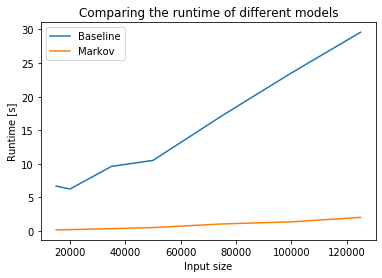

In [120]:
x = df['Baseline_runtimes']
y = df['Markov_runtimes']
                
plt.plot(x)
plt.plot(y)
plt.title("Comparing the runtime of different models")
plt.ylabel("Runtime [s]")
plt.xlabel("Input size")
plt.legend(['Baseline', 'Markov'])
plt.show();

# Visualizations

In [44]:
#Group pre-cluster df by case (case_id)
precluster_df = prepare_column_for_clustering(df['case_id'], df['concept:name'], df['concept:name'].unique())
precluster_df_by_case = precluster_df.groupby('case_id').sum()
precluster_df_by_case.head()

,A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Completeren aanvraag,A_ACCEPTED,O_SELECTED,A_FINALIZED,O_CREATED,O_SENT,W_Nabellen offertes,...,O_ACCEPTED,A_ACTIVATED,O_CANCELLED,W_Wijzigen contractgegevens,A_DECLINED,A_CANCELLED,W_Afhandelen leads,O_DECLINED,W_Nabellen incomplete dossiers,W_Beoordelen fraude
case_id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,3,1,1,1,1,1,7,...,1,1,0,0,0,0,0,0,0,0
1,1,1,1,5,1,2,1,2,2,10,...,1,1,1,0,0,0,0,0,0,0
2,1,1,1,9,1,3,1,3,3,25,...,1,1,2,1,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [45]:
#Perform PCA (2 component) on the data
pca2d = PCA(n_components = 2)
pca2d.fit(precluster_df_by_case)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [46]:
#Perform PCA (3 component) on the data
pca3d = PCA(n_components = 3)
pca3d.fit(precluster_df_by_case)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [47]:
#Create 2d dataframe
pca2d_df = pd.DataFrame(pca2d.transform(precluster_df_by_case))
pca2d_df.index.names = ['case_id']
pca2d_df.head()

,0,1
case_id,,
0,0.776662,-1.766118
1,4.483221,-3.996394
2,13.335660,-14.378924
3,-5.451243,3.194374
4,-5.451243,3.194374


In [48]:
#Create 3d dataframe
pca3d_df = pd.DataFrame(pca3d.transform(precluster_df_by_case))
pca3d_df.index.names = ['case_id']
pca3d_df.head()

,0,1,2
case_id,,,
0,0.776662,-1.766118,-3.315719
1,4.483221,-3.996394,-3.825478
2,13.335660,-14.378924,-10.449408
3,-5.451243,3.194374,-1.030985
4,-5.451243,3.194374,-1.030985


In [49]:
#Retrieve Clusters
df['concept:name cluster'], cluster_model = get_clusters(precluster_df)

NameError: name 'NR_OF_CLUSTERS' is not defined

In [ ]:
#Group regular df by case (case_id)
df_by_case = df.groupby('case_id').mean()[['concept:name cluster']]
df_by_case.head()

In [ ]:
#Merge the dataframes for 2d
vis2d_df = pd.merge(df_by_case, pca2d_df, on='case_id', how='left')
vis2d_df.columns = ['cluster', 'x_comp', 'y_comp']
vis2d_df.head()

In [ ]:
#Merge the dataframes for 3d
vis3d_df = pd.merge(df_by_case, pca3d_df, on='case_id', how='left')
vis3d_df.columns = ['cluster', 'x_comp', 'y_comp', 'z_comp']
vis3d_df.head()

In [ ]:
#Plot with low alpha
sns.lmplot('x_comp', 'y_comp', data=vis2d_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.25});

In [ ]:
#Plot with high alpha
sns.lmplot('x_comp', 'y_comp', data=vis2d_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.9});

In [ ]:
def random_colorscale(n):
    lst = []
    scale = 0
    initial = ['red','green','blue','orange','yellow','purple','black','pink','cyan','magenta']
    for i in range(n):
        if i < len(initial):
            color = initial[i]
        else:
            color = "#" + "%06x" % randint(0, 0xFFFFFF)
        lst.append((round(scale, 2), color))
        scale += 1/(n-1)
        
    
    return lst
#[(0, "red"), (0.14, "yellow"), (0.29, "purple"), (0.43, "green"), (0.57, "blue"), (0.71, "black"), (0.86, "orange"), (1, "pink")]
random_colorscale(4)
random_colorscale(NR_OF_CLUSTERS)

In [ ]:
lst = [(0, "red"), (0.14, "yellow"), (0.29, "purple"), (0.43, "green"), (0.57, "blue"), (0.71, "black"), (0.86, "orange"), (1, "pink")]
fig = go.Figure(data=[go.Scatter3d(
    x=vis3d_df['x_comp'],
    y=vis3d_df['y_comp'],
    z=vis3d_df['z_comp'],
    mode='markers',
    marker=dict(
        size=4,
        color=vis3d_df['cluster'],
        colorscale=random_colorscale(14),
        opacity=0.5
    )
)])
fig.show()

### Since the data is already converted, I markdowned the cell below. 

### This is how did we convert the .xes into .csv

# XES TO CSV
from pm4py.objects.log.importer.xes import importer as xes_importer

xesToCsv_BPI = xes_importer.apply("Datasets/BPI_Challenge_2012.xes")

xesToCsv_listo = []
xesToCsv_dic = {'no': -1}
xesToCsv_prev_attr = 'no'
xesToCsv_counter = 0
xesToCsv_cur_attr = 'no'

for i in tqdm(range(0, len(xesToCsv_BPI))):

    for j in range(0, len(xesToCsv_BPI[i])):
        xesToCsv_attr_list = list(xesToCsv_BPI[i][j])
    
        for k in range(0, len(xesToCsv_attr_list)):
            xesToCsv_prev_attr = xesToCsv_cur_attr
            xesToCsv_cur_attr = xesToCsv_attr_list[k]

            if xesToCsv_cur_attr not in xesToCsv_listo:
                xesToCsv_value = xesToCsv_dic[xesToCsv_prev_attr] + 1
            
                for key in xesToCsv_dic:
                    if xesToCsv_dic[key] >= xesToCsv_value:
                        xesToCsv_dic[key] += 1
            
                xesToCsv_dic[xesToCsv_cur_attr] = xesToCsv_value
                xesToCsv_listo.insert(xesToCsv_value, xesToCsv_cur_attr)
        
        xesToCsv_cur_attr = 'no'
        
        
xesToCsv_chain = []
xesToCsv_event = []

for i in tqdm(range(0, len(xesToCsv_BPI))):
    for j in range(0, len(xesToCsv_BPI[i])):
        xesToCsv_chain.append(i)
        xesToCsv_event.append(j)
        
xesToCsv_df_BPI= pd.DataFrame(index=[np.array(xesToCsv_chain), np.array(xesToCsv_event)], columns = xesToCsv_listo)

for i in tqdm(range(0, len(xesToCsv_BPI))):
    
    for j in range(0, len(xesToCsv_BPI[i])):

        xesToCsv_attr = xesToCsv_BPI[i][j]
        
        for a in xesToCsv_attr:
            xesToCsv_df_BPI.loc[(i, j), a] = xesToCsv_attr[a]
            
            
xesToCsv_df_BPI.to_csv('Datasets/BPI_2012.csv')

xesToCsv_attr_listo = []
xesToCsv_attr_dic = {'no': -1}
xesToCsv_prev_attr = 'no'
xesToCsv_counter = 0
xesToCsv_cur_attr = 'no'

for i in tqdm(range(0, len(xesToCsv_BPI))):
    xesToCsv_attr_list = list(xesToCsv_BPI[i].attributes)
    
    for k in range(0, len(xesToCsv_attr_list)):
        xesToCsv_prev_attr = xesToCsv_cur_attr
        xesToCsv_cur_attr = xesToCsv_attr_list[k]

        if xesToCsv_cur_attr not in xesToCsv_attr_listo:
            xesToCsv_value = xesToCsv_attr_dic[xesToCsv_prev_attr] + 1
            
            for key in xesToCsv_attr_dic:
                if xesToCsv_attr_dic[key] >= xesToCsv_value:
                    xesToCsv_attr_dic[key] += 1
            
            xesToCsv_attr_dic[xesToCsv_cur_attr] = xesToCsv_value
            xesToCsv_attr_listo.insert(xesToCsv_value, xesToCsv_cur_attr)
    
    xesToCsv_cur_attr = 'no'
    
    
xesToCsv_attr_chain = []

for i in tqdm(range(0, len(xesToCsv_BPI))):
    xesToCsv_attr_chain.append(i)
    

xesToCsv_df_BPI_attr = pd.DataFrame(index = [np.array(xesToCsv_attr_chain)], columns = xesToCsv_attr_listo)


for i in tqdm(range(0, len(xesToCsv_BPI))):

    xesToCsv_attr = xesToCsv_BPI[i].attributes
    
    for a in xesToCsv_attr:
        xesToCsv_df_BPI_attr.loc[i, a] = xesToCsv_attr[a]
        
xesToCsv_df_BPI_attr.to_csv('Datasets/BPI_attr_2012.csv')

if 'Unnamed: 0' in xesToCsv_df_BPI.columns:
    xesToCsv_df_BPI = xesToCsv_df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    xesToCsv_df_BPI_attr = xesToCsv_df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})

### Part of the baseline preprocessing

def changing_columns_names(df : pd.DataFrame):
    '''so far only works with the 2012 dataframe'''
    if(len(df.columns) == 8):
        df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
                      'concept:name', 'time:timestamp', 'time:weekday', 'time:hour']
    
    elif (len(df.columns) == 11):
        df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
                      'concept:name', 'time:timestamp', 'time:weekday', 'time:hour', 'time:time_between',
                     'time:day', 'time:event_count', 'time:busy_day']
    else:
        df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
                      'concept:name', 'time:timestamp', 'time:weekday', 'time:hour', 'time:time_between']
    
    return(df)

### Part of the baseline I think we are not using (and will not be) anymore

def cycles_shortcut(actions : list, concept_name : str, max_length : int, printing = False) -> list or bool:
    '''For saving the operating time, we will try to terminate the baseline early if we get into a loop
    max_length is the longest_trace parameter'''
    
    if(concept_name in actions): #the action has already been done
        
        if(actions[-1] == concept_name): #and it's the most recent action (self-loop)
            
            while(len(actions) < max_length): #filling the rest of the list with the current action if we're in a self-loop
                actions.append(concept_name)
        
        else: #it is not the most recent action
            placement = actions.index(concept_name) #locating the index of the "duplicate"
            aid_array = actions[placement:] #copying the values
            if (pritning):
                pass
                print("aid_array = ", aid_array)
            
            actions = actions + [0] * (max_length-len(actions)) #making [x, y, z, x] into [x, y, z, x, 0, 0, 0, ...]
            if (printing):
                pass
                print("actions = ", actions)
            
            for i in range(placement+1, max_length): #iterating only over all the indices of 0's in actions
                actions[i] = aid_array[(i-placement)%len(aid_array)] #copying the list's values over and over again
        
        return(actions) #This return has to be then the return of the iterated_expected_actions
    
    else:
        return(False)

### Some really weird function that nobody knows what is it doin'

testingBaseline_df_train = pd.read_csv('BPI_2012_train')
testingBaseline_df_train['time:timestamp'] = testingBaseline_df_train['time:timestamp'].apply(fix_time)
testingBaseline_df_train['time:time_between'] = testingBaseline_df_train['time:timestamp'].diff()
testingBaseline_df_train.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

testingBaseline_df_test = pd.read_csv('BPI_2012_test')
testingBaseline_df_test['time:timestamp'] = testingBaseline_df_test['time:timestamp'].apply(fix_time)
testingBaseline_df_test['time:time_between'] = testingBaseline_df_test['time:timestamp'].diff()
testingBaseline_df_test.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

#creates column with predicted data
def prediction(prev):
    return baseline_all_expected_events[0][prev]

testingBaseline_df_test['predicted'] = testingBaseline_df_test['concept:name'].apply(prediction)

#function that creates the 'correct' using a dataframe, the predcting column and the true column, it shows wether the prediction was correct
testingBaseline_df_test['shifted_actual'] = testingBaseline_df_test['concept:name'].shift(-1)
testingBaseline_df_test['shifted_case_id'] = testingBaseline_df_test['case_id'].shift(-1)
    
def apply_function(var):
    if var[2] == var[3]:
        return (var[0] == var[1])
        
    else:
        return (var[0] == 'editor:close_case')
        
testingBaseline_df_test['correct'] = testingBaseline_df_test[['predicted', 'shifted_actual', 'case_id', 'shifted_case_id']].apply(apply_function, axis=1)
testingBaseline_df_test = testingBaseline_df_test.drop(['shifted_actual', 'shifted_case_id'], axis=1)

def prediction(prev):
    return baseline_all_expected_events[1][prev]

testingBaseline_df_test['time:between_predicted'] = testingBaseline_df_test['concept:name'].apply(prediction)

#create column with absolute difference between predicted time and actual time
def time_difference(var):
    return abs((var[0] - var[1]).total_seconds())

def time_difference_if_correct(var):
    if var[0]:
        return abs((var[1] - var[2]).total_seconds())
    else:
        return 0

testingBaseline_df_test['time:absolute_prediction_off'] = testingBaseline_df_test[['time:time_between', 'time:between_predicted']].apply(time_difference, axis=1)
testingBaseline_df_test['time:absolute_prediction_correct'] = testingBaseline_df_test[['correct', 'time:time_between', 'time:between_predicted']].apply(time_difference_if_correct, axis=1)

#create column with relative difference between predicted time and actual time
def time_difference(var):
    return (var[0] - var[1]).total_seconds()

def time_difference_if_correct(var):
    if var[0]:
        return (var[1] - var[2]).total_seconds()
    else:
        return 0

testingBaseline_df_test['time:relative_prediction_off'] = testingBaseline_df_test[['time:time_between', 'time:between_predicted']].apply(time_difference, axis=1)
testingBaseline_df_test['time:relative_prediction_correct'] = testingBaseline_df_test[['correct', 'time:time_between', 'time:between_predicted']].apply(time_difference_if_correct, axis=1)


#Changed the code below to this to clean up the notebook. For refernce/troubleshooting, below code is markdowned, not erased
for element in [(False, 'mean'), (False, 'median'), (True, 'mean'), (True, 'median')]:
    timely_statistics(testingBaseline_df_test, relative=element[0], statistic=element[1])

### Previous operating time plot was made this way:

def plot_results(limits : list, runtimes_baseline : list, runtimes_clusterTree : list, runtimes_markov : list) -> None:
    '''Just plots the runtimes'''
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
    
    ax1.scatter(x=limits, y=runtimes, color='#420CDA')
    ax1.set_xlabel('Input size [n]', fontsize=13)
    ax1.set_ylabel('Operating time [s]', fontsize=13)
    
    ax2.scatter(x=limits, y=runtimes, color='#AB3334')
    ax2.set_xlabel('Input size [log(n)]', fontsize=13)
    ax2.set_ylabel('Operating time [log(s)]', fontsize=13)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    
    if(is_baseline):
        ax1.set_title('Runtime of the baseline algorithm', fontsize=16)
        ax2.set_title("Runtime of the baseline algorithm (log scale)", fontsize=16)
    else:
        ax1.set_title("Runtime of the cluster-tree algorithm", fontsize=16)
        ax2.set_title("Runtime of the cluster-tree algorithm (log scale)", fontsize=16)